# TEST 1: Leveraging LLMs for Feature Generation and Classification

Typically, if our data has $N$ features, we need around $10N$ data items to reach peak performance with classic classifiers like Logistic Regression. Therefore, if our vocabulary has 10,000 words, we would need around 1 million items in the training set to reach peak performance.

An interesting idea regarding this was explored in 2024 in [Balek, V., S'ykora, L., Sklen'ak, V., & Kliegr, T. (2024). LLM-based feature generation from text for interpretable machine learning. ArXiv, abs/2409.07132](https://arxiv.org/abs/2409.07132). The idea is to use an LLM to generate meaningful and interpretable features from text, and then use Logistic Regression for classification.

For example, in the movie plots dataset, we could have features like:
- "Is the protagonist an animal?" (0 or 1)
- "Does the plot indicate psychological suffering?" (0 or 1)

With a reasonable number of these features, our model could make predictions based on meaningful features instead of raw words.

## Objectives
* Perform feature extraction for a particular dataset
* Compare performance and explainability of classifiers with different approaches. 

## Rules

I highlight a few elements of our usual rules:

* You are **NOT ALLOWED** to use AI to generate any code you are asked to make yourself. This includes ChatGPT, CoPilot and all similar generators.
* You are **NOT ALLOWED** to use Google or any other search engine.
* You are **ALLOWED** to use the offical documentations for libraries: 
    * [sklearn](https://scikit-learn.org/)
    * [numpy](https://numpy.org/)
    * [matplotlib](https://matplotlib.org/)
    * [google AI studio](https://aistudio.google.com/)
* You are **ALLOWED** to use previous code from this course as basis.
* You **MUST** use the university's proctoring software to show you are complying with these rules
* This task is **INDIVIDUAL**. DO NOT share your code or results with anyone else.

## Tasks and Deliverables

* At any point, refer to [Balek et al.](https://arxiv.org/abs/2409.07132). 
* Make a well-commented code to solve each one of the tasks below.
* Each task will be evaluated as:
    * Insufficient: task is not done, off-topic, or low-effort
    * In process: task is incomplete, done with a clear conceptual error, or comments 
    * Proficient: everything works and comments are enough to understand what is being done
    * Advanced: everything works, comments are enough to understand what is being done, and code is well organized and formated using functions, dataclasses, and other adequate structures.
* This task should be finished by the end of the class.
* After you are finished, submit the executed notebook in our LMS system.

### 1. Dataset Preparation:
Adapting Balek et al.'s strategy to our movie plot classification case, create a dataset with at least 100 labeled items and at least 5 meaningful features. None of the features can be the class itself ("is this a drama plot?"). Use a clear strategy to avoid exceeding free tier quotas. Store data locally in a format of your choice.

### 2. Classification:
Use the generated features to train a Logistic Regression model. Use cross-validation to select the best hyperparameters. Report accuracy and f1-score for your classifier.

### 3. Performance Comparison
Compare the performance of the following approaches:
1. Traditional Bag-of-Words
2. LLM-generated features with Logistic Regression
3. Direct classification using LLM

Use a bar plot to show the performance differences (choose either accuracy or F1-score).

### 4. Improvement Strategies
Determine whether labeling more items would improve system performance. Use data to justify your answer.


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv
import google.generativeai as genai
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [32]:
load_dotenv()
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
genai.configure(api_key=GEMINI_API_KEY)

In [33]:
df = pd.read_csv('https://raw.githubusercontent.com/tiagoft/NLP/main/wiki_movie_plots_drama_comedy.csv')
df.head()

,Plot,Genre
0,The film is about a family who move to the sub...,comedy
1,Before heading out to a baseball game at a nea...,comedy
2,The plot is that of a black woman going to the...,comedy
3,On a beautiful summer day a father and mother ...,drama
4,A thug accosts a girl as she leaves her workpl...,drama


Accuracy: 0.78


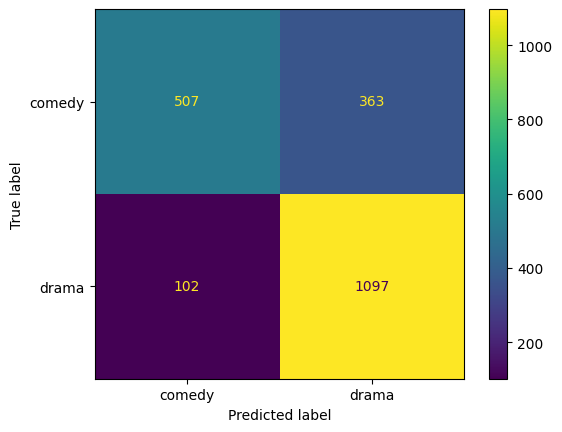

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

classifier = VotingClassifier([('lr', LogisticRegression()),
                               ('rf', RandomForestClassifier()),
                               ('nb', BernoulliNB())])


model_ensemble = Pipeline([('vectorizer',
                      TfidfVectorizer(
                          stop_words='english',
                          binary=True,
                      )), ('classifier', classifier)])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Plot'], df['Genre'], test_size=0.2)
# Train the pipeline
model_ensemble.fit(X_train, y_train)
y_pred = model_ensemble.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_ensemble.classes_)
disp.plot()
plt.show()

In [35]:
import os
from dotenv import load_dotenv
import google.generativeai as genai
import json
from tqdm import tqdm
import time

load_dotenv()

df_ = df.sample(100)
X = df.iloc[1]['Plot']
y = df.iloc[1]['Genre']

In [36]:
print(len(df_))

100


In [37]:
# Start the use of the API
genai.configure(api_key=GEMINI_API_KEY)

i = 0
current_responses = []
while i < len(df_):
    plot = df_.iloc[i]['Plot']

    # Make our prompt here
    prompt = f"""
    You will be given the task of analyzing a movie plot. I will ask you some questions and you will 
    return the answer to them as either 1 (for yes) or 0 (for no). If you are in doubt, make your best guess.

    Also, identify if the plot genre is DRAMA or COMEDY.

    Answer the questions as a JSON file, in the format: 

    {{
    "Q1" : "Answer to Q1",
    "Q2" : "Answer to Q2",
    "Q3" : "Answer to Q3",
    "Q4" : "Answer to Q4",
    "Q5" : "Answer to Q5",
    "Q6" : "Answer to Q6",
    "Q7" : "Answer to Q7",
    "Q8" : "Answer to Q8",
    "Q9" : "Answer to Q9",
    "Q10" : "Answer to Q10",
    "LLM_Genre" : "DRAMA" or "COMEDY"
    }}

    The questions are:

    Q1: Is the protagonist an animal?
    Q2: Can that movie make me rethink my life choices?
    Q3: Am I going to cry when I watch the movie?
    Q4: Is the plot absurd or exaggerated?
    Q5: Could the situations in the movie realistic happen to an average person?
    Q6: Is the emotional tone of the narrative primarily lighthearted or humorous?
    Q7: Are conflicts resolved in ways that are exaggerated, absurd, or intentionally amusing?
    Q8: Do the characters and their relationships lean towards eccentricity or caricature rather than realism?
    Q9: Does humor play a central role in driving the story forward?
    Q10: Is the intended effect to leave the audience laughing or feeling uplifted rather than reflecting on serious issues?


    The movie plot is: {plot}
    """

    generation_config = genai.GenerationConfig(
        max_output_tokens=100,
        temperature=0.0,
        response_mime_type='application/json'
    )

    # Use our prompt 
    model = genai.GenerativeModel(model_name="gemini-2.0-flash")

    try:
        response = model.generate_content(prompt,
                                        generation_config=generation_config)
        response_dict = json.loads(response.text)
        current_responses.append(response_dict)
        i = i + 1
        print(i)
    except Exception as e:
        print("Wait...", e)
        time.sleep(10)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
Wait... 429 Resource has been exhausted (e.g. check quota).
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
Wait... 429 Resource has been exhausted (e.g. check quota).
34
35
Wait... 429 Resource has been exhausted (e.g. check quota).
36
37
Wait... 429 Resource has been exhausted (e.g. check quota).
Wait... 429 Resource has been exhausted (e.g. check quota).
Wait... 429 Resource has been exhausted (e.g. check quota).
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
Wait... 429 Resource has been exhausted (e.g. check quota).
54
Wait... 429 Resource has been exhausted (e.g. check quota).
Wait... 429 Resource has been exhausted (e.g. check quota).
55
Wait... 429 Resource has been exhausted (e.g. check quota).
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
Wait... 429 Resource has been exhausted (e.g. check quota).
Wait... 429 Resource has been exhausted (e.g. check quota).
72
Wait... 429 Resource has been exhausted (e.g. check quota).
73
Wait... 42

In [38]:
len(current_responses), len(df_)

(100, 100)

In [39]:
df_features = pd.DataFrame(current_responses)
df_ = df_.iloc[0:100]

In [40]:
df_features.shape

(100, 11)

In [41]:
df_['Q1'] = list( df_features['Q1'].astype(int) )
df_['Q2'] = list( df_features['Q2'].astype(int) )
df_['Q3'] = list( df_features['Q3'].astype(int) )
df_['Q4'] = list( df_features['Q4'].astype(int) )
df_['Q5'] = list( df_features['Q5'].astype(int) )
df_['LLM_Genre'] = list( df_features['LLM_Genre'] )

In [47]:
df_.head()

,Plot,Genre,Q1,Q2,Q3,Q4,Q5,LLM_Genre
5956,"In 2003, Grant Taylor (Alex Kendrick) is the h...",drama,0,1,1,0,1,DRAMA
6749,Shane Jacobson plays Boots who takes his fathe...,comedy,0,1,1,0,1,DRAMA
6200,"Will Montgomery (Ben Foster), a lone rebelliou...",drama,0,1,1,0,1,DRAMA
9676,Sindhuraj alias Sindhu (Shankar) is a carefree...,drama,0,0,0,0,1,COMEDY
8929,Anandi Devi (Meena Kumari) is an old widow who...,drama,0,1,1,0,1,DRAMA


In [43]:
df_.dtypes

Plot         object
Genre        object
Q1            int64
Q2            int64
Q3            int64
Q4            int64
Q5            int64
LLM_Genre    object
dtype: object

In [44]:
import numpy as np
accuracies = []
for _ in range(50):
    X_train, X_test, y_train, y_test = train_test_split(
        df_[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']],
        df_['Genre'],
        test_size=0.2,
    )

    model = BernoulliNB()

    # Train the pipeline
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

print(np.mean(accuracies))

0.8269999999999998


In [45]:
print(accuracy_score(df_['Genre'].str.upper(), df_['LLM_Genre'].str.upper()))

0.84
